In [2]:
import os
import sys

# General
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# Tensorflows
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model

# Metrics
from sklearn.model_selection import train_test_split
from cf_matrix import make_confusion_matrix
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, roc_curve, auc, balanced_accuracy_score)

# Sklearn preprocessing and utility
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Sampling
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imbl

# Feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import f_classif

# DNN trainig stats
from livelossplot import PlotLossesKeras

# Custom helper functions
from utils import *
from data_io import *
from data_representation import *

# Plot settings
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Setup

In [3]:
# Fix GPU, comment out on single GPU systems
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
 # Check for GPU support
if tf.test.gpu_device_name(): 
    print('Default GPU Device: \
    {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:    /device:GPU:0


In [5]:
# Configure Google Colab
def set_colab_folder(path='MyDrive/Colab Notebooks/ML4HC/project2'):
  if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    path = os.path.join('/content/drive/', path)
    sys.path.append(path)
    %cd $path
  else:
    print('Not running on CoLab')

In [6]:
set_colab_folder()

Not running on CoLab


### Datasets


In [7]:
# Fix data directory
data_dir = "data"

In [8]:
# Get dataset shapes
shapes = get_dataset_shapes()
pd.DataFrame(shapes)

,0,1
0,C_elegans_acc_seq.csv,"(2200, 2)"
1,C_elegans_test_split.csv,"(330, 2)"
2,C_elegans_train_split.csv,"(1540, 2)"
3,C_elegans_validation_split.csv,"(330, 2)"
4,human_dna_test_hidden_split.csv,"(30021, 1)"
5,human_dna_test_split.csv,"(33333, 2)"
6,human_dna_train_split.csv,"(500000, 2)"
7,human_dna_validation_split.csv,"(33333, 2)"


# C Elegans
Training and performance report on the C. Elegans dataset

In [9]:
X_train, y_train = get_data(species='worm', mode='train', form='split')
X_val, y_val     = get_data(species='worm', mode='val',   form='split')
X_test, y_test   = get_data(species='worm', mode='test',  form='split')

100%|██████████| 330/330 [00:00<00:00, 33240.16it/s]


In [10]:
# Use 0/1 labels instead of -1/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

Class distribution on training


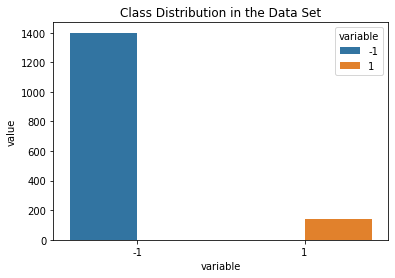

In [11]:
print("Class distribution on training")
plot_class_distribution(y_train)

In [12]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Training: Counter({0: 1400, 1: 140})
Validation: Counter({0: 300, 1: 30})
Test: Counter({0: 300, 1: 30})


## Data preparation

In [13]:
# One-Hot encode data
K = 1 # encode single nucleotides i.e. 1-mers
X_train = one_hot_encoding(X_train, k=K)
X_val = one_hot_encoding(X_val, k=K)
X_test = one_hot_encoding(X_test, k=K)

In [14]:
# Work with dense numpy arrays
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

## Training

#### Class weights

In [15]:
cls_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train),  y=y_train)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}

### Over-/Undersample
Explored various sampling techniques, but settled for using class weights with best results

##### Oversampling

In [16]:
# smote = SMOTE()  # ratio='minority')
# X_os, y_os = smote.fit_sample(X_train, y_train)

##### Undersampling

In [17]:
# rus = RandomUnderSampler(random_state=42)
# X_us, y_us = rus.fit_resample(X_train, y_train)
# print("{:.0%} of dataset kept.".format(len(y_us)/len(y_train)))

##### Over- & Undersampling combinded

In [18]:
# smote_tomek = SMOTETomek(random_state=42)   
# X_ous_1, y_ous_1  = smote_tomek.fit_resample(X_train, y_train)
# print('Count before: {}'.format(Counter(y_train)))
# print("Lenght of over-undersampled dataset is {:.0%} of the initial one.".format(len(y_ous_1)/len(y_train)))
# print('Count after over-undersampling: {}'.format(Counter(y_ous_1)))

### Network
Small Dense Neural Network architecture with Dropout and BatchNormalization to improve training stability and generalization

In [19]:
def create_dense_net(X, y):
    
    inputs = Input(shape=(X.shape[1],))
    
    x = Dense(32, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(8, activation='relu')(x)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [20]:
dense_net = create_dense_net(X_train, y_train)
dense_net.summary()
# tf.keras.utils.plot_model(dense_net, show_shapes=True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 246)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)               

### Training Grid Search
Perform feature selection and do a grid search over number of features to feed as input into the network, best results have been achieved with a selection of 175 input nucleotides

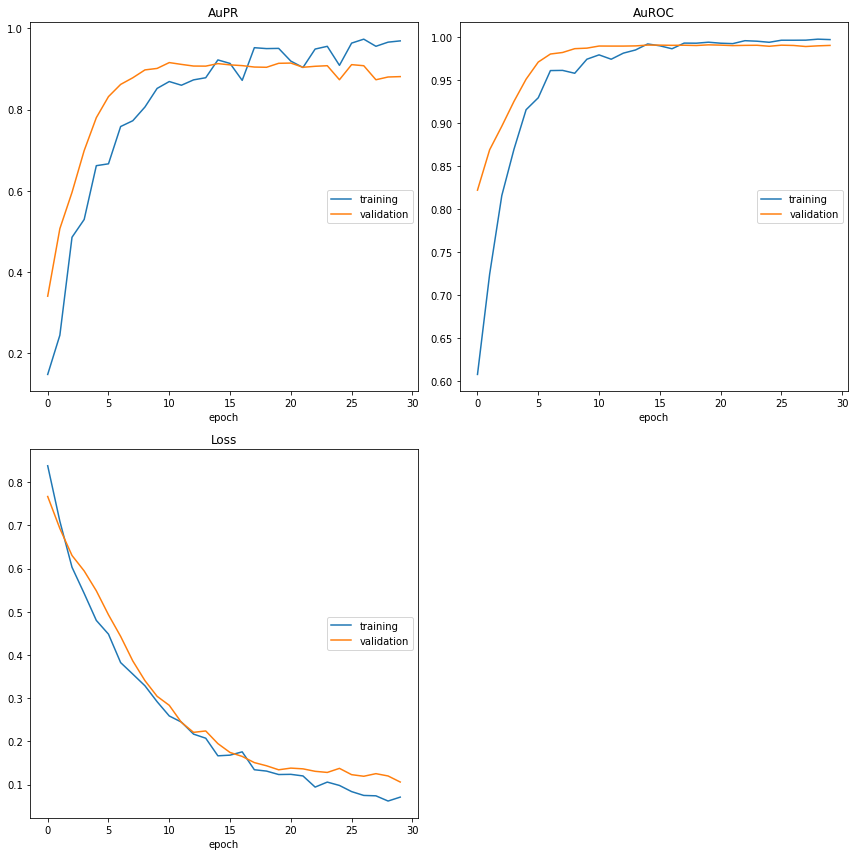

AuPR
	training         	 (min:    0.148, max:    0.973, cur:    0.969)
	validation       	 (min:    0.341, max:    0.916, cur:    0.881)
AuROC
	training         	 (min:    0.608, max:    0.998, cur:    0.997)
	validation       	 (min:    0.822, max:    0.991, cur:    0.990)
Loss
	training         	 (min:    0.062, max:    0.838, cur:    0.071)
	validation       	 (min:    0.106, max:    0.767, cur:    0.106)

Epoch 00030: val_loss improved from 0.11916 to 0.10582, saving model to ./model/dense_net_best_checkpoint
INFO:tensorflow:Assets written to: ./model/dense_net_best_checkpoint/assets
25/25 [==============================] - 2s 80ms/step - loss: 0.0709 - AuROC: 0.9972 - AuPR: 0.9692 - val_loss: 0.1058 - val_AuROC: 0.9904 - val_AuPR: 0.8813


In [26]:
EPOCHS = 30
BATCH_SIZE = 64

# Store performance results of the grid on end of training network and best validation loss network
k_best_res= pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})
k_best_res_checkpoint = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

# for k in range(25,250,25): # Run grid search
for k in [175]: # Run on best only
    
    # K-Best feature selection
    selKBest = SelectKBest(f_classif, k=k)
    selKBest.fit(X_train, y_train)

    X_fs = selKBest.transform(X_train)
    X_val_fs = selKBest.transform(X_val)
    X_test_fs = selKBest.transform(X_test)
    
    # Create network
    dense_net = create_dense_net(X_fs, y_train)
    
    # Use Adam optimizer  
    opt=tf.keras.optimizers.Adam()
    
    # Initialize network
    dense_net.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
#             "accuracy",
            tf.keras.metrics.AUC(curve="ROC", name="AuROC"),
            tf.keras.metrics.AUC(curve="PR", name="AuPR"),
        ],
    )
    
     # Store checkpoints for best validation loss model
    save_best_cb = tf.keras.callbacks.ModelCheckpoint(
        './model/dense_net_best_checkpoint', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=False, mode='min', save_freq='epoch'
    )

    # Train
    history = dense_net.fit(
        X_fs, y_train,
        epochs=EPOCHS,
        batch_size = BATCH_SIZE,
        class_weight=cls_weight_dict,
        validation_data=(X_val_fs, y_val),
        callbacks=[PlotLossesKeras(), save_best_cb]
    )
    
    # Load best validation loss model
    dense_net_best = tf.keras.models.load_model('./model/dense_net_best_checkpoint')
    
    # Report scores on test set for end-of-training and best validation loss models
    _, _, res_k = pred_results(clf=dense_net, X=X_test_fs, y=y_test, model_name="select {} best".format(k), figsize=None, model_type='keras')
    _, _, res_k_check = pred_results(clf=dense_net_best, X=X_test_fs, y=y_test, model_name="select {} best".format(k), figsize=None, model_type='keras')
    k_best_res = pd.concat([k_best_res,res_k], axis=0).reset_index(drop=True)
    k_best_res_checkpoint = pd.concat([k_best_res_checkpoint,res_k_check], axis=0).reset_index(drop=True)

In [27]:
# Report grid search results and highlight best scores
print("Results end of training")
display(k_best_res.style.highlight_max(color = 'lightgreen', axis = 0))
print()
print("Results best validation loss")
display(k_best_res_checkpoint.style.highlight_max(color = 'lightgreen', axis = 0))

Results end of training


,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,select 175 best,0.960606,0.933333,0.981556,0.850411



Results best validation loss


,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,select 175 best,0.960606,0.933333,0.981556,0.850411


In [28]:
dense_net.save(f"./models/worm_dnn", overwrite=False)

INFO:tensorflow:Assets written to: ./models/worm_dnn/assets


In [30]:
species = "worm"
split = "test"
predictor_identifier = "dnn_select175"
threshold = 0.5

print("Shape of hidden dataset", X_test.shape)
X_test_fs = selKBest.transform(X_test)
y_proba = dense_net.predict(X_test_fs) # use previously selected network for predictions on the hidden test data
# y_pred = [-1 if y < threshold else 1 for y in y_proba] # predict -1/1 labels as original data

# pd.DataFrame(y_pred).to_csv(f"./predictions/{species}_{split}_{predictor_identifier}.csv") # store -1/1 labels
pd.DataFrame(y_proba).to_csv(f"./predictions/worm_test/proba_{species}_{split}_{predictor_identifier}.csv") # store predicted probabilities

Shape of hidden dataset (330, 246)


### SHAP analysis
Perform SHAP analysis to better understand model decision process

In [22]:
import shap
shap.initjs()

In [23]:
X_fs = selKBest.transform(X_train)

shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
dense_explainer = shap.DeepExplainer(dense_net, X_fs)

keras is no longer supported, please use tf.keras instead.


In [24]:
X_test_fs = selKBest.transform(X_test)
dense_shap_values = dense_explainer.shap_values(X_test_fs)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Indicates high importance for the predictions of the nucleotides close to the splice site

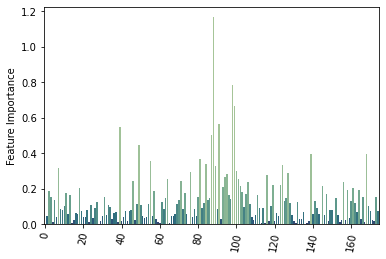

In [37]:
fig, ax = plt.subplots(figsize=(6,4))

names = list(range(175))
scores = np.abs(np.sum(dense_shap_values[0], axis=0))

pal = sns.color_palette("crest", 175)
rank = np.argsort(np.argsort(scores))
ax = sns.barplot(
    x=names,
    y=scores,
    palette=np.array(pal[::-1])[rank]
).set(ylabel="Feature Importance")

locs = list(range(0, 175, 20))
locs, labels = plt.xticks(locs, [names[i] for i in locs], rotation=80)

plt.savefig("./figures/dnn_select175_worm_shap.svg")

# Human DNA

In [31]:
X_train_h, y_train_h = get_data(species='human', mode='train', form='split')
X_val_h, y_val_h     = get_data(species='human', mode='val', form='split')
X_test_h, y_test_h   = get_data(species='human', mode='test', form='split')
X_hidden_h, _   = get_data(species='human', mode='hidden', form='split')

100%|██████████| 30021/30021 [00:01<00:00, 22339.62it/s]


In [32]:
# Use 0/1 labels
y_train_h[y_train_h < 0] = 0
y_val_h[y_val_h < 0] = 0
y_test_h[y_test_h < 0] = 0

### Class Distribution

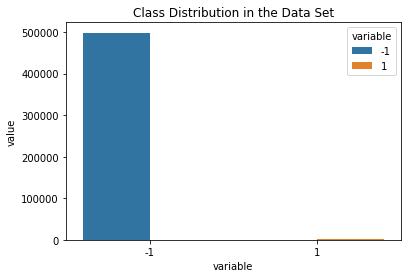

In [33]:
# Plot class distribution on training
plot_class_distribution(y_train_h)

## Data preparation
One-Hot encode single nucleotides

In [34]:
print("Convert training sets")
X_tot_h = np.vstack([X_train_h, X_val_h, X_test_h])
X_tot_h = one_hot_encoding(X_tot_h)
l_train_h, l_val_h, l_test_h = len(X_train_h), len(X_val_h), len(X_test_h)
X_train_h, X_val_h, X_test_h = X_tot_h[:l_train_h], X_tot_h[l_train_h:l_train_h+l_val_h], X_tot_h[-l_test_h:]

print("Convert test set")
X_hidden_h = one_hot_encoding(X_hidden_h)

Convert training sets
Convert test set


##### Report imbalance on the different splits

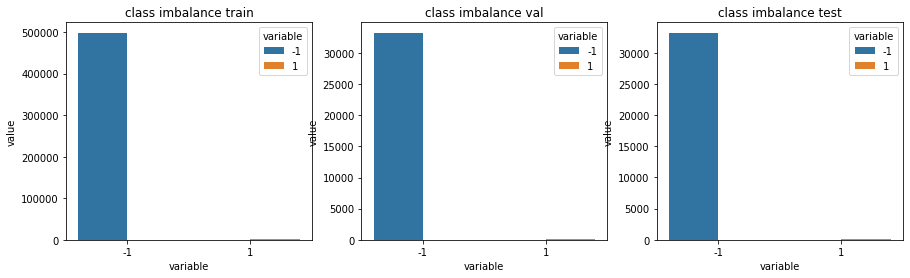

In [35]:
fig = plt.figure(figsize=(15,4))
#fig, axes = plt.subplots(1, 3, )
gs = fig.add_gridspec(1, 3)

for i, y_ in enumerate([y_train_h, y_val_h, y_test_h]):
  ax = fig.add_subplot(gs[i])
  plot_class_distribution(y_)
  ax.set_title("class imbalance " + ['train','val', 'test'][i])

# Training

#### Class weights

In [36]:
cls_weights_h = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_h),  y=y_train_h)
cls_weight_dict_h = {0: cls_weights_h[0], 1: cls_weights_h[1]}

#### Sampling
Various sampling techniques similar to the worm dataset have been tested, but again class weights have been found to work the best

#### Training grid search
Perform a grid search over the number of nucleotides to select for feeding into the network, 225 has been found to work best

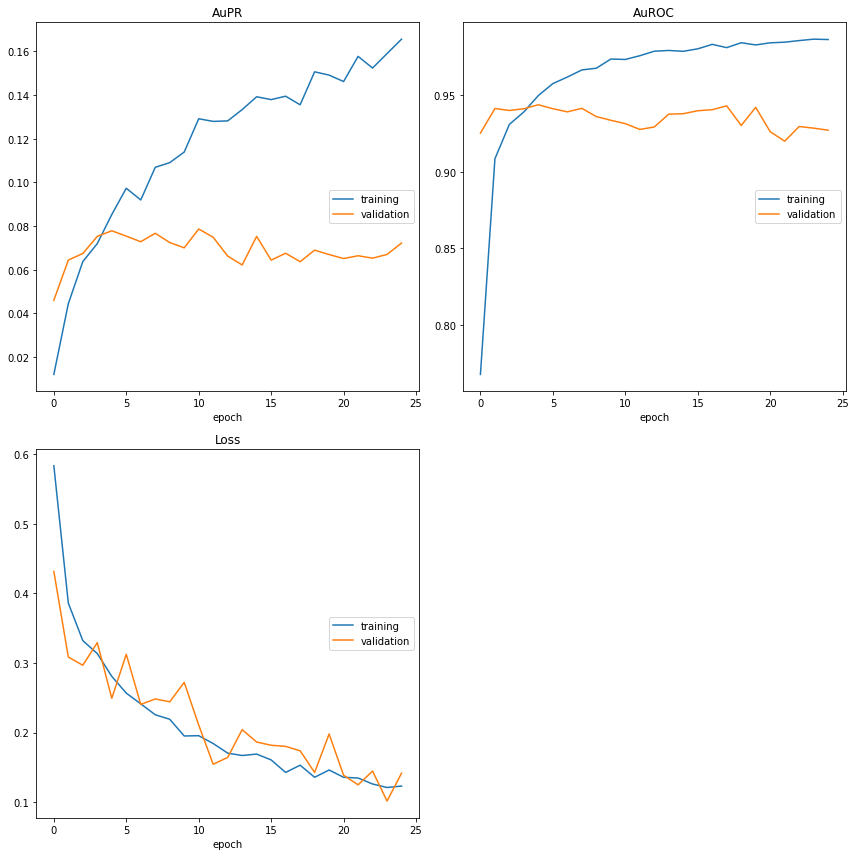

AuPR
	training         	 (min:    0.012, max:    0.166, cur:    0.166)
	validation       	 (min:    0.046, max:    0.079, cur:    0.072)
AuROC
	training         	 (min:    0.768, max:    0.987, cur:    0.987)
	validation       	 (min:    0.920, max:    0.944, cur:    0.927)
Loss
	training         	 (min:    0.121, max:    0.583, cur:    0.123)
	validation       	 (min:    0.102, max:    0.432, cur:    0.142)

Epoch 00025: val_loss did not improve from 0.10182
489/489 [==============================] - 7s 14ms/step - loss: 0.1233 - AuROC: 0.9865 - AuPR: 0.1656 - val_loss: 0.1417 - val_AuROC: 0.9273 - val_AuPR: 0.0722
INFO:tensorflow:Assets written to: ./model/dense_net_train_human_iter4/assets


In [37]:
EPOCHS = 25
BATCH_SIZE = 1024

k_best_res= pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})
k_best_res_checkpoint = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

# for k in range(50,300,25): # initial grid for testing
for k in [225]:
    
    # K-Best feature selection
    selKBest = SelectKBest(f_classif, k=k)
    selKBest.fit(X_train_h, y_train_h)

    X_fs = selKBest.transform(X_train_h)
    X_val_fs = selKBest.transform(X_val_h)
    X_test_fs = selKBest.transform(X_test_h)
    
    for i in range(5):

        # Initialize network, larger architectures have been tested
        # but the same architecture as used for the worm dataset
        # has been found to work best also on the human DNA
        # we attribute this to the fact, that also here only a small portion
        # of the nucleotides close to the splice sites are really highly predicitive
        dense_net = create_dense_net(X_fs, y_train_h)

        # Use Adam optimizer with default configuration
        opt=tf.keras.optimizers.Adam()

        # Initialize the network
        dense_net.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
    #             "accuracy",
                tf.keras.metrics.AUC(curve="ROC", name="AuROC"),
                tf.keras.metrics.AUC(curve="PR", name="AuPR"),
            ],
        )

         # Store checkpoints for best validation loss model
        save_best_cb = tf.keras.callbacks.ModelCheckpoint(
            f"./model/dense_net_best_checkpoint_human_iter{i}", monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=False, mode='min', save_freq='epoch'
        )

        # Fit the model
        history = dense_net.fit(
            X_fs, y_train_h,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            class_weight=cls_weight_dict_h,
            validation_data=(X_val_fs, y_val_h),
            callbacks=[PlotLossesKeras(), save_best_cb]
        )
        
        
        dense_net.save(f"./model/dense_net_train_human_iter{i}", overwrite=True)

        # Load best validation model and report scores on test set
        dense_net_best = tf.keras.models.load_model(f"./model/dense_net_best_checkpoint_human_iter{i}")
        _, _, res_k = pred_results(clf=dense_net, X=X_test_fs, y=y_test_h, model_name=f"select {k} best {i}", figsize=None, model_type='keras')
        _, _, res_k_check = pred_results(clf=dense_net_best, X=X_test_fs, y=y_test_h, model_name=f"select {k} best {i}", figsize=None, model_type='keras')
        k_best_res = pd.concat([k_best_res,res_k], axis=0).reset_index(drop=True)
        k_best_res_checkpoint = pd.concat([k_best_res_checkpoint,res_k_check], axis=0).reset_index(drop=True)

In [38]:
# Report results
print("Results end of training")
display(k_best_res.style.highlight_max(color = 'lightgreen', axis = 0))
print()
print("Results best validation loss")
display(k_best_res_checkpoint.style.highlight_max(color = 'lightgreen', axis = 0))

Results end of training


,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,select 225 best 0,0.924399,0.880606,0.941105,0.116886
1,select 225 best 1,0.919839,0.854356,0.940773,0.108451
2,select 225 best 2,0.942489,0.808205,0.915897,0.116426
3,select 225 best 3,0.912789,0.884368,0.933153,0.133688
4,select 225 best 4,0.943299,0.822989,0.918000,0.109752



Results best validation loss


,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,select 225 best 0,0.931719,0.874693,0.938475,0.119079
1,select 225 best 1,0.937359,0.848766,0.939357,0.110965
2,select 225 best 2,0.942819,0.832334,0.926842,0.128437
3,select 225 best 3,0.945159,0.867056,0.933170,0.146453
4,select 225 best 4,0.961840,0.803532,0.923040,0.126406


#### Select best network according to AuPRC score

In [40]:
k_best_res["prc_auc"].argmax()
best_network = None
best_train = k_best_res["prc_auc"].max()
best_val = k_best_res_checkpoint["prc_auc"].max()
if best_train > best_val:
    best_network = tf.keras.models.load_model(f"./model/dense_net_train_human_iter{k_best_res['prc_auc'].argmax()}")
else:
    best_network = tf.keras.models.load_model(f"./model/dense_net_best_checkpoint_human_iter{k_best_res_checkpoint['prc_auc'].argmax()}")
    
# Verify best model performance
X_test_fs = selKBest.transform(X_test_h)
_, _, res_k = pred_results(clf=best_network, X=X_test_fs, y=y_test_h, model_name=f"select {k} best {i}", figsize=None, model_type='keras')
display(res_k)

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,select 225 best 4,0.945159,0.867056,0.93317,0.146443


In [41]:
best_network.save(f"./models/human_dnn", overwrite=False)

INFO:tensorflow:Assets written to: ./models/human_dnn/assets


#### Predict on hidden test set

In [42]:
species = "human"
split = "test_hidden"
predictor_identifier = "dnn_select225"
threshold = 0.5

print("Shape of hidden dataset", X_hidden_h.shape)
X_hidden_fs = selKBest.transform(X_hidden_h)
y_proba = best_network.predict(X_hidden_fs) # use previously selected network for predictions on the hidden test data
# y_pred = [-1 if y < threshold else 1 for y in y_proba] # predict -1/1 labels as original data

# pd.DataFrame(y_pred).to_csv(f"./predictions/{species}_{split}_{predictor_identifier}.csv") # store -1/1 labels
pd.DataFrame(y_proba).to_csv(f"./predictions/human_hidden/proba_{species}_{split}_{predictor_identifier}.csv") # store predicted probabilities

Shape of hidden dataset (30021, 1194)


In [43]:
species = "human"
split = "test"
predictor_identifier = "dnn_select225"
threshold = 0.5

print("Shape of hidden dataset", X_test_h.shape)
X_test_fs = selKBest.transform(X_test_h)
y_proba = best_network.predict(X_test_fs) # use previously selected network for predictions on the hidden test data
# y_pred = [-1 if y < threshold else 1 for y in y_proba] # predict -1/1 labels as original data

# pd.DataFrame(y_pred).to_csv(f"./predictions/{species}_{split}_{predictor_identifier}.csv") # store -1/1 labels
pd.DataFrame(y_proba).to_csv(f"./predictions/human_test/proba_{species}_{split}_{predictor_identifier}.csv") # store predicted probabilities

Shape of hidden dataset (33333, 1194)
